## Overview

This week, we're learning about ensemble methods, APIs, and natural language processing. Now we're going to put these skills to the test!

You've been hired by Netflix to examine what factors lead to certain ratings for movies. Given that Netflix does not currently store this type of data, your boss has suggested that you collect ratings and reviews data from IMDB. Netflix is no stranger to machine learning, however:

- Netflix uses random forests and decision trees to predict what types of movies an individual user may like.
- Using unsupervised learning techniques, they are able to continually update suggestions, listings, and other features of its user interface.
- Netflix, however, hasn't focused on collecting data on the top movies of all time, and would like to add some of them to their offerings based on popularity and other factors.

**Point:** Your boss isn't sure where to start on this project, so your task is to collect the data, build a random forest, and examine its feature importances to understand what factors contribute to ratings.


## Project Summary
Acquire data from IMDB, and use whatever metrics you can collect to predict whether a movie is highly rated.

When you've finished your analysis, Netflix would like a report detailing your findings, with recommendations as to next steps.

Here are some questions to keep in mind:

- What factors are the most direct predictors of rating?
- You can use rating as your target variable. But it's up to you whether to treat it as continuous, binary, or multiclass.

**Goal**: Completed Jupyter notebook that includes modeling using a random forest and an blog post explaining your findings.

---

## Requirements
This is deliberately open ended. There is no starter code. It's up to you how to acquire the data, store the data, and what features you want to use. 

We expect you to use a **tree-based model**, but the rest of the decisions are up to you. 

We will be looking for the following things:
 - A clear problem statement & description of the goals of your study to be included in the final report
 - Data from IMDB
 - Cleaned and refined data
 - Visualization. Plots that describe your data and evaluate your model.
 - Tree-based models (use any combination of ensemble techniques: random forests, bagging, boosting). 
 - A blog post presenting the results of your findings as a report to Netflix, including:
  - a problem statement,
  - summary statistics of the various factors (e.g. year, number of ratings, etc.),
  - your model,
  - at least 2 graphics,
  - and your recommendations for next steps!


## All the imports

In [442]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from bs4 import BeautifulSoup
import requests
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imdbpie import Imdb
imdb = Imdb()
imdb = Imdb(anonymize=True) # to proxy requests
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

%matplotlib inline

## Scrape data from IMDB.com using imdbpie API and BeautifulSoup
#### 1. Find lists of imbd_ids to iteratively dissect for target data

In [400]:
# Get list of imbd_ids for top 250 rated movies on IMBD

best = imdb.top_250()

top_250 = []
def str_lists(data, new_list, class_id):
    for i in data:
        new_list.append((i[class_id]).encode('ascii','ignore'))
    return new_list

str_lists(best, top_250, class_id = "tconst")
len(top_250)

250

In [80]:
# Get list of imdb_ids for oscar winning films (best picture winners)

url = "http://www.imdb.com/search/title?count=100&groups=oscar_best_picture_winners&sort=year,desc&ref_=nv_ch_osc_2"
r = requests.get(url)
page = r.content
soup = BeautifulSoup(page, 'lxml')

results = soup.findAll("img")
results = str(results).split("data-tconst=\"")

oscars = []
for i in results: 
    oscars.append(i[:9])
    
oscars = oscars[1:]
len(oscars)

89

In [396]:
# Get list of imdb_ids for cult classic films

url = "http://www.imdb.com/list/ls052232899/"
r = requests.get(url)
page = r.content
soup = BeautifulSoup(page, 'lxml')

results = soup.findAll(class_ = "info")
results = str(results).split("<a href=\"/title/")

cult_classics = []
for i in results: 
    cult_classics.append(i[:9])
    
cult_classics = cult_classics[1:]
len(cult_classics)

128

In [109]:
# Get list of imdb_ids for top drama films

url = "http://www.imdb.com/genre/drama/?ref_=gnr_mn_dr_mp"
r = requests.get(url)
page = r.content
soup = BeautifulSoup(page, 'lxml')

results = soup.findAll(class_ = "title")
results = str(results).split("<a href=\"/title/")

drama = []
for i in results: 
    drama.append(i[:9])
    
drama = drama[1:]
len(drama)

48

In [106]:
# Get list of imdb_ids for top comedy films

url = "http://www.imdb.com/genre/comedy/?ref_=gnr_mn_co_mp"
r = requests.get(url)
page = r.content
soup = BeautifulSoup(page, 'lxml')

results = soup.findAll(class_ = "title")
results = str(results).split("<a href=\"/title/")

comedy = []
for i in results: 
    comedy.append(i[:9])
    
comedy = comedy[1:]
len(comedy)

47

In [107]:
# Get list of imdb_ids for top action films

url = "http://www.imdb.com/genre/action/?ref_=gnr_mn_ac_mp"
r = requests.get(url)
page = r.content
soup = BeautifulSoup(page, 'lxml')

results = soup.findAll(class_ = "title")
results = str(results).split("<a href=\"/title/")

action = []
for i in results: 
    action.append(i[:9])
    
action = action[1:]
len(action)

40

In [110]:
# Get list of imdb_ids for top animation films

url = "http://www.imdb.com/genre/animation/?ref_=gnr_mn_an_mp"
r = requests.get(url)
page = r.content
soup = BeautifulSoup(page, 'lxml')

results = soup.findAll(class_ = "title")
results = str(results).split("<a href=\"/title/")

animation = []
for i in results: 
    animation.append(i[:9])
    
animation = animation[1:]
len(animation)

48

In [114]:
# Get list of imdb_ids for top thriller films

url = "http://www.imdb.com/genre/thriller/?ref_=gnr_mn_th_mp"
r = requests.get(url)
page = r.content
soup = BeautifulSoup(page, 'lxml')

results = soup.findAll(class_ = "title")
results = str(results).split("<a href=\"/title/")

thriller = []
for i in results: 
    thriller.append(i[:9])
    
thriller = thriller[1:]
len(thriller)

44

In [117]:
# Get list of imdb_ids for top western films

url = "http://www.imdb.com/genre/western/?ref_=gnr_mn_we_mp"
r = requests.get(url)
page = r.content
soup = BeautifulSoup(page, 'lxml')

results = soup.findAll(class_ = "title")
results = str(results).split("<a href=\"/title/")

western = []
for i in results: 
    western.append(i[:9])
    
western = western[1:]
len(western)

49

In [112]:
# Get list of imdb_ids for top fantasy films

url = "http://www.imdb.com/genre/fantasy/?ref_=gnr_mn_fa_mp"
r = requests.get(url)
page = r.content
soup = BeautifulSoup(page, 'lxml')

results = soup.findAll(class_ = "title")
results = str(results).split("<a href=\"/title/")

fantasy = []
for i in results: 
    fantasy.append(i[:9])
    
fantasy = fantasy[1:]
len(fantasy)

40

In [119]:
# Get list of imdb_ids for top romance films

url = "http://www.imdb.com/genre/romance/?ref_=gnr_mn_ro_mp"
r = requests.get(url)
page = r.content
soup = BeautifulSoup(page, 'lxml')

results = soup.findAll(class_ = "title")
results = str(results).split("<a href=\"/title/")

romance = []
for i in results: 
    romance.append(i[:9])
    
romance = romance[1:]
len(romance)  

46

In [88]:
# Get imdb_ids for most popular movies

url = 'http://www.imdb.com/chart/moviemeter?ref_=nv_mv_mpm_8'
r = requests.get(url)
page = r.content
soup = BeautifulSoup(page, 'lxml')

results = soup.findAll(class_ = "titleColumn")
results = str(results).split("n<a href=\"/title/")

pop_list = []
for i in results: 
    pop_list.append(i[:9])
    
pop_list = pop_list[1:]
len(pop_list)

100

#### 2. Create scraping function for each imdb_id collected above

In [460]:
# Create empty lists for future dataframe
year = []
month = []
rating = []
votes = []
cert = []
title_name = []
cast_1 = []
cast_2 = []
cast_3 = []
cast_4 = []
direct = []
writer_1 = []
writer_2 = []
genre_1 = []
genre_2 = []
genre_3 = []


# Define function to extract all elements from individual pages, iteratively work through imdb_ids 
def get_all_info(id_list):
    for i in id_list: 
        url = "http://www.imdb.com/title/"+ i
        r = requests.get(url)
        if str(r) == "<Response [200]>":
            title = imdb.get_title_by_id(i)
            try:
                year.append(title.year)
            except: 
                year.append("no_data")
            try:
                month.append(int(((title.release_date).encode('ascii','ignore').split("-"))[1]))
            except: 
                month.append("no_data")
            try:
                rating.append(title.rating)
            except:
                rating.append("no_data")
            try: 
                votes.append(title.votes)
            except: 
                votes.append("no_data")
            try: 
                cert.append((title.certification).encode('ascii','ignore'))
            except:
                cert.append("no_data")
            try:
                title_name.append((title.title).encode('ascii','ignore'))
            except:
                title_name.append("no_data")
            try:
                cast_1.append(str((title.cast_summary)[0]).split("\'")[1])
            except: 
                cast_1.append("no_data")
            try:
                cast_2.append(str((title.cast_summary)[1]).split("\'")[1])
            except: 
                cast_2.append("no_data")
            try:
                cast_3.append(str((title.cast_summary)[2]).split("\'")[1])
            except:
                cast_3.append("no_data")
            try:
                cast_4.append(str((title.cast_summary)[3]).split("\'")[1])
            except: 
                cast_4.append("no_data")
            try:
                direct.append(str((title.directors_summary)[0]).split("\'")[1])
            except:
                direct.append("no_data")
            try:
                writer_1.append(str((title.writers_summary)[0]).split("\'")[1])
            except:
                writer_1.append("no_data")
            try:
                writer_2.append(str((title.writers_summary)[1]).split("\'")[1])
            except:
                writer_2.append("no_data")
            try:
                genre_1.append(((title.genres)[0]).encode('ascii','ignore'))
            except:
                genre_1.append("no_data")
            try:
                genre_2.append(((title.genres)[1]).encode('ascii','ignore'))
            except:
                genre_2.append("no_data")
            try:
                genre_3.append(((title.genres)[2]).encode('ascii','ignore'))
            except:
                genre_3.append("no_data")
        else:
            pass
    
    # Zip into dataframe
    df = pd.DataFrame(zip(title_name, cert, year, month, rating, votes, genre_1, genre_2, genre_3, direct,\
                            cast_1, cast_2, cast_3, cast_4, writer_1, writer_2))
    df.columns = ["title", "cert", "year", "month", "rating", "votes", "genre_1", "genre_2", "genre_3",\
                    "direct", "cast_1", "cast_2", "cast_3", "cast_4", "writer_1", "writer_2"]
    return df

#### 3.  Run functions for each list of imbd_ids. Export after each run in order to avoid kernel interruption.

In [461]:
top_250_df = get_all_info(top_250)
top_250_df.to_csv('/Users/ebzimm/Desktop/imdb_top_250.csv')

In [69]:
pop_list_df = get_all_info(pop_list)
pop_list_df.to_csv('/Users/ebzimm/Desktop/imdb_pop_list.csv')

In [79]:
oscars_df = get_all_info(oscars)
oscars_df.to_csv('/Users/ebzimm/Desktop/imdb_oscars.csv')

In [95]:
cult_df = get_all_info(cult_classics)
cult_df.to_csv('/Users/ebzimm/Desktop/imdb_cult.csv')

In [104]:
drama_df = get_all_info(drama)
drama_df.to_csv('/Users/ebzimm/Desktop/imdb_drama.csv')

In [105]:
comedy_df = get_all_info(comedy)
comedy_df.to_csv('/Users/ebzimm/Desktop/imdb_comedy.csv')

In [108]:
action_df = get_all_info(action)
action_df.to_csv('/Users/ebzimm/Desktop/imdb_action.csv')

In [111]:
animation_df = get_all_info(animation)
animation_df.to_csv('/Users/ebzimm/Desktop/imdb_animation.csv')

In [113]:
fantasy_df = get_all_info(fantasy)
fantasy_df.to_csv('/Users/ebzimm/Desktop/imdb_fantasy.csv')

In [116]:
thriller_df = get_all_info(thriller)
thriller_df.to_csv('/Users/ebzimm/Desktop/imdb_thriller.csv')

In [118]:
western_df = get_all_info(western)
western_df.to_csv('/Users/ebzimm/Desktop/imdb_western.csv')

In [122]:
romance_df = get_all_info(romance)
romance_df.to_csv('/Users/ebzimm/Desktop/imdb_romance.csv')

#### 4. After exporting and compiling results in Excel (including duplicat removal), import .csv to pandas dataframe

In [489]:
# Import final .csv
df = pd.read_csv('/Users/ebzimm/GA-DSI/Projects/projects-weekly/project-06/imdb.csv')

# Drop Nan values; ~7% of data (37 rows)
df = df.dropna()

# Change "month" to numeric
df["month"] = df["month"].replace("no_data","")
df["month"] = pd.to_numeric(df["month"])

# Reset index
df = df.reset_index(drop=True)

In [490]:
# Check results
print len(df)
df.head()

472


,title,cert,year,month,rating,votes,genre_1,genre_2,genre_3,direct,cast_1,cast_2,cast_3,cast_4,writer_1,writer_2
0,The Shawshank Redemption,R,1994,10.0,9.3,1722149.0,Crime,Drama,no_data,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,Stephen King,Frank Darabont
1,The Godfather,R,1972,3.0,9.2,1176965.0,Crime,Drama,no_data,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,Mario Puzo,Francis Ford Coppola
2,The Godfather: Part II,R,1974,12.0,9.0,806763.0,Crime,Drama,no_data,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,Francis Ford Coppola,Mario Puzo
3,The Dark Knight,PG-13,2008,7.0,9.0,1707952.0,Action,Crime,Drama,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,Jonathan Nolan,Christopher Nolan
4,12 Angry Men,Approved,1957,4.0,8.9,458935.0,Crime,Drama,no_data,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,Reginald Rose,Reginald Rose


## Refine results
#### a. Set performance metrics for "cast," "director," and "writers"

In [491]:
# Identify frequency of all actors across all movies
# Create list of top 5% of actors (ranked by frequency in database)
# Count how many top actors are cast per movie

cast = pd.DataFrame([df["cast_1"],df["cast_2"],df["cast_3"],df["cast_4"]]).T
cast = (cast.stack().value_counts()).head(70) #70 = top 5% of actors

cast_1 = []
cast_2 = []
cast_3 = []
cast_4 = []

def count_list(data, param_list, new_list):
    for i in data:
        if i in param_list:
            new_list.append(1)
        else: 
            new_list.append(0)
    return new_list

# Redefine columns as binary - 1 for top actor, else 0
df['cast_1'] = pd.DataFrame(count_list(df['cast_1'], cast, cast_1))
df['cast_2'] = pd.DataFrame(count_list(df['cast_2'], cast, cast_2))
df['cast_3'] = pd.DataFrame(count_list(df['cast_3'], cast, cast_3))
df['cast_4'] = pd.DataFrame(count_list(df['cast_4'], cast, cast_4))

# Create new column with sum of binary columns
df['top_actors'] = df['cast_1'] + df['cast_2'] + df['cast_3'] + df['cast_4']

# Remove old columns
del df['cast_1']
del df['cast_2']
del df['cast_3']
del df['cast_4']

In [492]:
# Identify frequency of all writers across all movies
# Create list of top 5% of writers (ranked by frequency in database)
# Count how many top writers are cast per movie

writers = pd.DataFrame([df["writer_1"],df["writer_2"]]).T
writers = (writers.stack().value_counts()).head(32) # 32 = top 5% of writers

writer_1 = []
writer_2 = []

def count_list(data, param_list, new_list):
    for i in data:
        if i in param_list:
            new_list.append(1)
        else: 
            new_list.append(0)
    return new_list

# Redefine columns as binary - 1 for top writer, else 0
df['writer_1'] = pd.DataFrame(count_list(df['writer_1'], writers, writer_1))
df['writer_2'] = pd.DataFrame(count_list(df['writer_2'], writers, writer_2))

# Create new column with sum of binary columns
df['top_writers'] = df['writer_1'] + df['writer_2']

# Remove old columns
del df['writer_1']
del df['writer_2']

In [493]:
# Identify frequency of directors across all movies
# Create list of top 10% of directors (ranked by frequency in database)
# Assign binary variable for top-director or non-top-director

directs = pd.DataFrame(df["direct"]).T
directs = (directs.stack().value_counts()).head(31) # 31 = top 10% of directors
len(directs)

directors = []

def count_list(data, param_list, new_list):
    for i in data:
        if i in param_list:
            new_list.append(1)
        else: 
            new_list.append(0)
    return new_list

# Redefine columns as binary - 1 for top director, else 0
df['direct'] = pd.DataFrame(count_list(df['direct'], directs, directors))

In [494]:
# Check results
df.head()

,title,cert,year,month,rating,votes,genre_1,genre_2,genre_3,direct,top_actors,top_writers
0,The Shawshank Redemption,R,1994,10.0,9.3,1722149.0,Crime,Drama,no_data,0,1,1
1,The Godfather,R,1972,3.0,9.2,1176965.0,Crime,Drama,no_data,1,1,1
2,The Godfather: Part II,R,1974,12.0,9.0,806763.0,Crime,Drama,no_data,1,3,1
3,The Dark Knight,PG-13,2008,7.0,9.0,1707952.0,Action,Crime,Drama,1,1,2
4,12 Angry Men,Approved,1957,4.0,8.9,458935.0,Crime,Drama,no_data,1,1,0


#### 2. Create dummy variables for certification & month

In [495]:
# Remove unrelated labels (19% of data) and replace "Not Rated" with "Unrated" (consolidation)
ratings = ['12A','15A', 'Approved', 'E','G','GP','M','MA15+','Passed','R18+','R21','TV-14','TV-G''TV-MA','TV-PG']
df["cert"] = df["cert"].replace('Not Rated','Unrated')
for i in ratings:
    df = df[df.cert != i]

# Create dummy variables for certification
cert = pd.get_dummies(df['cert'])
cert = pd.DataFrame(cert)
cert.head()

# Delete old column in df
del df['cert']

In [496]:
# Create dummy variables for month
month = pd.get_dummies(df['month'])
month.columns = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month = pd.DataFrame(month)
month.head()

# Delete old column in df
del df['month']

#### 3. Final data set!

In [497]:
# Concatenate dummy variables with original df and check results
df = pd.concat([df,month,cert], axis=1)
print len(df)
df.head()

379


,title,year,rating,votes,genre_1,genre_2,genre_3,direct,top_actors,top_writers,...,Nov,Dec,NC-17,PG,PG-13,R,TV-G,TV-MA,Unrated,no_data
0,The Shawshank Redemption,1994,9.3,1722149.0,Crime,Drama,no_data,0,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,The Godfather,1972,9.2,1176965.0,Crime,Drama,no_data,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,The Godfather: Part II,1974,9.0,806763.0,Crime,Drama,no_data,1,3,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,The Dark Knight,2008,9.0,1707952.0,Action,Crime,Drama,1,1,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,Schindler's List,1993,8.9,881972.0,Biography,Drama,History,1,2,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Data Visualization

Rating Mean: 7.69841688654
Rating Median: 8.1


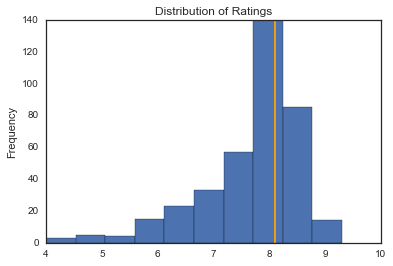

In [515]:
# Distribution of "rating"
df['rating'].plot(kind = 'hist')
plt.axvline(np.median(df['rating']), color = "orange")
plt.title('Distribution of Ratings')
    
print "Rating Mean:",np.mean(df['rating'])
print "Rating Median:",np.median(df['rating'])

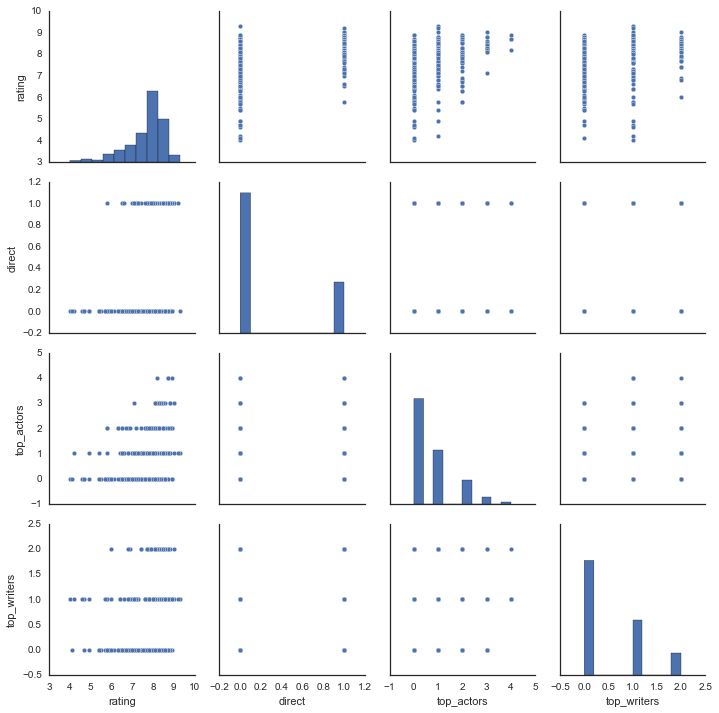

In [516]:
# Eyeball for correlations
sns.pairplot(df, vars = ["rating", "direct", "top_actors", "top_writers"])

## Tree-Based Model Building with Ensemble Techniques

In [475]:
# Set a threshold and convert target to binary (1 if rating is above 8.5, 0 if rating is below)
# Define X and y variables

threshold = 8.3 # Mean and median of top_250 listings

y = df['rating'].apply(lambda x: 1 if x > threshold else 0)
X = df.copy()

# Food for thought: what could each of these offer if I left them in the model?
del X['votes']
del X['rating']
del X['title']
del X['year']
del X['genre_1']
del X['genre_2']
del X['genre_3']

In [476]:
# Declare estimators and fit models

dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2)
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

dt.fit(X, y)
rf.fit(X, y)
et.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

,dt_importance,rf_importance,et_importance
top_actors,0.391030,0.181599,0.178687
writer_count,0.208251,0.151466,0.122985
direct,0.095331,0.078537,0.066619
Feb,0.100490,0.077368,0.053745
R,0.000000,0.056388,0.054356
Nov,0.000000,0.050116,0.056715
Dec,0.000000,0.044317,0.045473
Unrated,0.000000,0.043605,0.039335
Mar,0.000000,0.040884,0.030907
Jun,0.000000,0.032212,0.030930


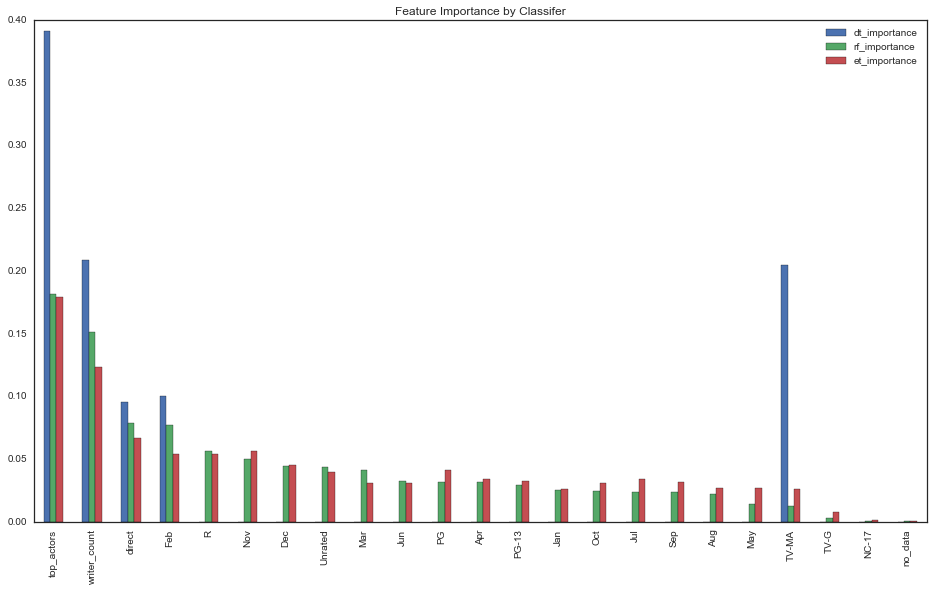

In [528]:
# Find feature importances
importances = rf.feature_importances_

# Plot feature importances, sorted by ascending order on RandomForestClassifier
importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)

                           
importances.plot(kind='bar', figsize=(16,9))
plt.title('Feature Importance by Classifer')
importances.sort_values(by = "rf_importance", ascending = False).head(10)

In [478]:
# Check scores for each estimator

cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=21)

def classifier(model, name):
    s = cross_val_score(model, X , y , cv=cv, n_jobs = -1) # n_jobs = -1 means run on all threads
    print("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))

classifier(dt, "Decision Tree")
classifier(rf, "Random Forest")
classifier(et, "Extra Trees")

Decision Tree Score:	0.829 ± 0.024
Random Forest Score:	0.777 ± 0.079
Extra Trees Score:	0.785 ± 0.061


In [480]:
# Predictions and probabilities

y_pred_rf = rf.predict(X)
y_prob_rf = rf.predict_proba(X)

In [481]:
# Classification Report

print classification_report(y,y_pred_rf)

             precision    recall  f1-score   support

          0       0.97      0.92      0.95       313
          1       0.70      0.86      0.78        66

avg / total       0.92      0.91      0.92       379



In [482]:
# Confusion Matrix

conmat = np.array(confusion_matrix(y, y_pred_rf, labels=[1,0]))
print "Confusion Matrix"
pd.DataFrame(conmat, index=['>8.5','<8.5'],
                            columns=['>8.5','<8.5'])


Confusion Matrix


,>8.5,<8.5
>8.5,57,9
<8.5,24,289


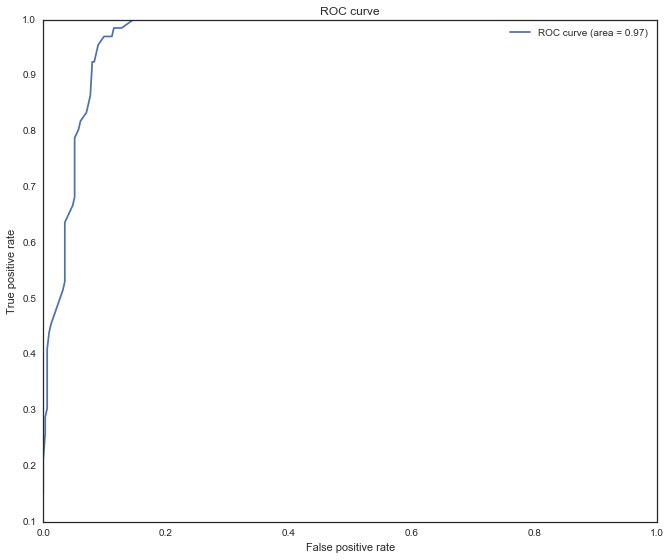

In [483]:
# Plot ROC Curve

y_pred_rf = rf.predict_proba(X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y, y_pred_rf)
ROC_AUC = auc(fpr_rf, tpr_rf)

plt.figure(figsize=[11,9])
plt.plot(fpr_rf, tpr_rf, label='ROC curve (area = %0.2f)' % ROC_AUC)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## A blog post presenting the results of your findings as a report to Netflix, including:
- a problem statement
- summary statistics of the various factors (e.g. year, number of ratings, etc.)
- your model
- at least 2 graphics
- and your recommendations for next steps

https://betsy-zimm.squarespace.com/blog